<a href="https://colab.research.google.com/github/sharon-raj-1718/CE888/blob/main/CE888/PROJECT_2/ASSIGNMENT_1/TweetEval_emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#                  **TweetEval-based Multi-class tweet classification**









# Loading of libraries

In [11]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import urllib.request
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import f1_score
import re
import requests
import string
from nltk.corpus import stopwords
import seaborn as sns
import re
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import  CountVectorizer, TfidfVectorizer
from sklearn import svm

# Load the dataset

In [12]:
train_text = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/train_text.txt",encoding='utf-8',sep="\t", header=None)
train_label = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/train_labels.txt",encoding='utf-8',sep="\t", header=None)
validate_text = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/val_text.txt",encoding='utf-8',sep="\t", header=None)
validate_label = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/val_labels.txt",encoding='utf-8',sep="\t", header=None)
test_text = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/test_text.txt",encoding='utf-8',sep="\t", header=None)
test_label = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/test_labels.txt",encoding='utf-8',sep="\t", header=None)
map = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/mapping.txt",encoding='utf-8',sep="\t", header=None)

In [13]:
train_text.columns= ["text"]
train_label.columns= ["label"]
validate_text.columns= ["text"]
validate_label.columns= ["label"]
test_text.columns= ["text"]
test_label.columns= ["label"]
map.columns= ["label","emotion"]

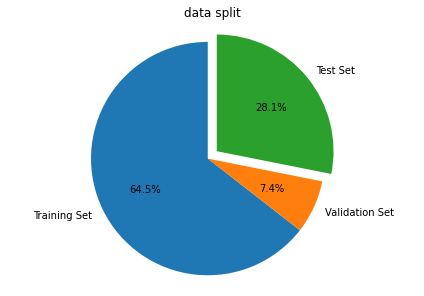

In [14]:
labels = ['Training Set', 'Validation Set', 'Test Set'] 
sizes = [len(train_label), len(validate_label), len(test_label)] 
explode = (0, 0, 0.1)
fig1, ax1 = plt.subplots() 
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')
plt.tight_layout() 
plt.title("data split") 
plt.show()

# Preprocessing

In [15]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)


#Pulls Out all the HTML related tags ,unwanted characters and Amend text to lowercase

In [16]:
def clean_tweet(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    text = text.strip().lower()
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    
    return text

# Tokenizing function used for all the data

In [17]:
def text_preprocessing(text):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_tweet(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    combined_text = ' '.join(tokenized_text)
    return combined_text

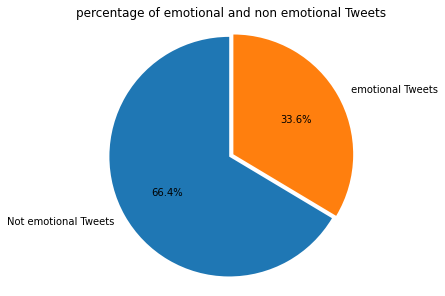

In [18]:
non_emo = train_label[train_label.label == 0].shape[0]
emo = train_label[train_label.label == 1].shape[0]

labels = ['Not emotional Tweets', ' emotional Tweets']
sizes = [non_emo, emo]
fig1, ax1 = plt.subplots()
explode = (0.02, 0.02)  
ax1.pie(sizes, explode= explode, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  
plt.tight_layout()
plt.title("percentage of emotional and non emotional Tweets")
plt.show()

#sucession the  dataframe and some further preprocessing

In [19]:

con_train = pd.concat([train_text,train_label], axis=1)
con_val = pd.concat([validate_text,validate_label], axis=1)
con_test = pd.concat([test_text,test_label], axis=1)

emotion_train = pd.merge(con_train,map, on='label')
emotion_validate = pd.merge(con_val,map, on='label')
emotion_test = pd.merge(con_test,map, on='label')

train_validate = pd.concat([emotion_train,emotion_validate])

emotion_train1 = train_validate.copy()
emotion_train1['clean_t'] = emotion_train1['text'].apply(str).apply(lambda x: text_preprocessing(x))
emotion_train1['clean_t'] = emotion_train1['clean_t'].str.replace('user','')
emotion_train1['clean_t'] = emotion_train1['clean_t'].str.replace('amp','')
emotion_train1



,text,label,emotion,clean_t
0,“Worry is a down payment on a problem you may ...,2,optimism,worry is a down payment on a problem you may n...
1,I saved him after ordering him to risk his lif...,2,optimism,i saved him after ordering him to risk his lif...
2,@user Uggh that's really horrible. You're not ...,2,optimism,uggh thats really horrible youre not a bad pe...
3,Love is when all your happiness and all your s...,2,optimism,love is when all your happiness and all your s...
4,“ My courage always rises at every attempt to ...,2,optimism,my courage always rises at every attempt to in...
...,...,...,...,...
369,Alaina and I are at 90 days on our snap streak...,2,optimism,alaina and i are at 90 days on our snap streak so
370,@user || I smell your fear.,2,optimism,i smell your fear
371,@user @user @user Seems legit. I always flinch...,2,optimism,seems legit i always flinch right before i ...
372,#faith is like #oil but #fear is like #dust ea...,2,optimism,faith is like oil but fear is like dust easily...


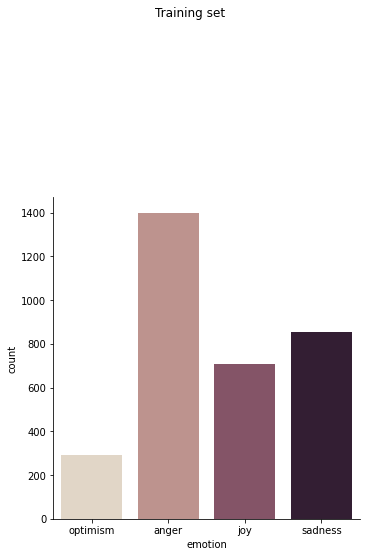

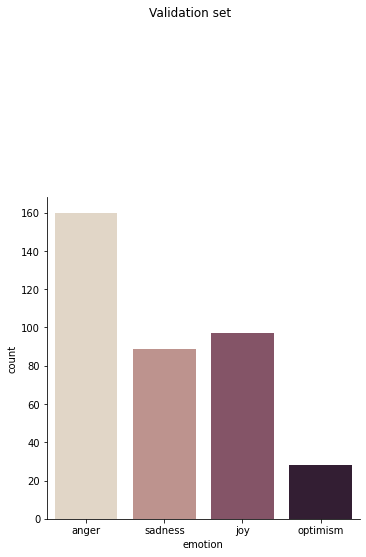

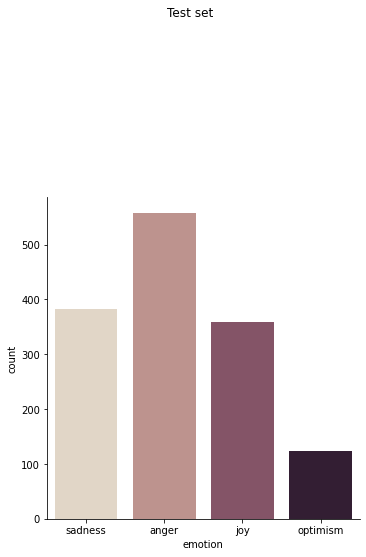

In [20]:
g = (sns.catplot(x="emotion", kind="count", palette="ch:.25", data=emotion_train))
g.fig.suptitle("Training set", y=1.5)
plt.show()

v = sns.catplot(x="emotion", kind="count", palette="ch:.25", data=emotion_validate)
v.fig.suptitle("Validation set", y=1.5)
plt.show()

t = sns.catplot(x="emotion", kind="count", palette="ch:.25", data=emotion_test)
t.fig.suptitle("Test set", y=1.5)
plt.show()

In [ ]:
emotion_1 = emotion_train1[emotion_train1 ['emotion'] == 'emotion']['clean_t']
emotion_0 = emotion_train1[emotion_train1 ['emotion'] == 'non-emotion']['clean_t'] 


# Vectorizing for Offensive dataset

In [ ]:
vectorizer = TfidfVectorizer(stop_words="english",preprocessor=clean_tweet,ngram_range=(1,2))
training_features = vectorizer.fit_transform(train_validate["text"])    
test_features = vectorizer.transform(emotion_test["text"])  


# Training the model

In [ ]:
model = LinearSVC()
model.fit(training_features, train_validate["emotion"])
y_pred = model.predict(test_features)

# Evaluation metrics

In [ ]:
score = f1_score(emotion_test["emotion"], y_pred,average='macro')

print("Accuracy for the emotion: {:.2f}".format(score*100,2))

Accuracy for the emotion: 62.61
